### Mixture of Non-Linear Regression

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov  9 12:00:31 2018

@author: Hansheng 
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display
import scipy.linalg
from itertools import combinations
from numpy import linalg
from numpy.linalg import matrix_rank
from scipy.sparse.linalg import svds, eigs
import random
import time
from scipy.optimize import minimize
import math
import matplotlib.mlab as mlab
from scipy import integrate
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import scipy.stats
import csv
import statistics as stats
import pandas as pd
import colorsys
from scipy.integrate import quad
from scipy.integrate import dblquad

from sympy import sin, cos, symbols



In [ ]:
def func(x,beta):
    '''
    define the nonlinear regression function in the least squares
    
    '''
    beta = beta.ravel()
    x = x.ravel()
    
    func_val = (beta[0]**2)*x[0] + 0.5*beta[0]*beta[1]*x[1]+0.5*beta[1]*x[1]**2+beta[0]*beta[1]
    return func_val

In [ ]:
def lmo(beta,X,y,sigma,f):
    '''
    Return the objective function of subproblem in the Frank-Wofle
    '''
    n = len(X)
    p = len(X[0])
    obj = 0
    for i in range(n):
        obj = obj - np.exp(-0.5*(y[i] - func(X[i],beta))**2 /(sigma**2))/f[i]
    return obj  


#===============================================================================================
def sollmo(X,y,sigma,f):
    '''
    Solve linear minimization oracle
    this is an nonconvex problem with respect to beta, the result is approximal
    return a new supporting vector g and corresponding beta
    
    '''
    n = len(X)
    p = len(X[0])
    
    #nonconvex algorithms are sensitive to initialization!!!!
    #initialize beta0 with OLS solution or 0 or random
    #beta0 = np.reshape(np.dot( np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)) 
    #beta0 = np.zeros((p,1))
    
    #beta0 = np.reshape(np.random.uniform(0,5,p),(p,1))
    
    #minimize exponential sum approximately
    #nonconvex problem
    
    #OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),jac = jacobian, method = 'BFGS')
    #OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),method = 'Powell')
    #note that Powell method does not need the gradient information
    
    num_rdn = 5
    opt_fun = np.zeros(num_rdn)
    opt_x = np.zeros((num_rdn,p))
    for rdn in range(num_rdn):
        beta0 = np.reshape(np.random.uniform(0,5,p),(p,1))
        OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),method = 'Powell')
        opt_fun[rdn] = OptResult.fun
        opt_x[rdn] = OptResult.x
    #print(opt_fun)
    #print(np.where(opt_fun == opt_fun.min()))
    min_rdn = np.where(opt_fun == opt_fun.min())[0][0]  
    #print(min_rdn)
   
    beta_sol = opt_x[min_rdn]
    print('beta_sol', beta_sol)
    g = np.zeros((n,1))
    for i in range(n):
        g[i] = 1/(np.sqrt(2*np.pi)*sigma)* np.exp(-0.5*(y[i] - func(X[i],beta_sol))**2 /(sigma**2))
    return g,beta_sol
#===========================================================================================================



def FW_FC(f,alpha,P,n):
    '''
    solve the fully corective step using classic FW
    warm start with f from last iteration
    P each column of P is a candidate component
    return new f, and f as a convex combination of columns of P with coefficients alpha
    '''
    iter = 5000
    
    k = len(P[0])
    alpha = np.append(alpha,0)
    alpha = np.reshape(alpha,(k,1))
    for t in range(1,iter):
        g = 1/f
        g = np.reshape(g,(1,n))
        s = np.argmax(np.matmul(g,P))
        gamma = 2/(t+2)
        f = (1-gamma)*f +gamma*np.reshape(P[:,s],(n,1))
        temp = np.zeros((k,1))
        temp[s] = 1
        alpha = (1-gamma)*np.reshape(alpha,(k,1))+gamma*temp
    return f,alpha

def NPMLE_FW(X,y,iter,sigma):
    '''
    Use FW algorithm to solve NPMLE problem of MLR  
    sigma is estimated before
    
    Input
    X: covariate matrix
    y: response variable
    iter: number of iterations
    sigma: std of noise
    
    Output
    f: n * J, atomic likelihood vectors in active set
    B: p * J, coefficients corresponding to vectors in active set
    alpha: J * 1, mixing proportions of vectors in active set
    L_rec: neg-log likelihood over iterations
    temp: final neg-log likelihood
    
    '''  
    n = len(X)
    p = len(X[0])
    
    L_rec = []
    
    #initialize beta0 and f
    #beta0 = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)) #beta0 is OLS solution
    #beta0 = np.zeros((p,1))
    
    beta0 = np.reshape(np.random.uniform(-5,5,p),(p,1)) #random initialization
                       
    f = np.zeros((n,1))
    for i in range(n):
        f[i] = 1/(np.sqrt(2*np.pi)*sigma)* np.exp(-0.5*(y[i] - func(X[i],beta0))**2 /(sigma**2))
    
    # initialize P,B
    # P active set
    # B beta's corresponding to columns of P
    P = np.zeros((n,1))
    P[:,0] = f.ravel()
    B = np.zeros((p,1))
    B[:,0] = beta0.ravel()
    
    # intialize coefficients of convex combinations
    alpha = np.array([1]) 
    
    for t in range(1,iter):
        #solve LMO
        g, beta_sol = sollmo(X,y,sigma,f)
        
        g = np.reshape(g,(n,1))
        beta_sol = np.reshape(beta_sol,(p,1))
        P = np.append(P,g,axis = 1)
        B = np.append(B,beta_sol,axis = 1)
        
        #fully corrective step wrt current active set P
        f, alpha = FW_FC(f,alpha,P,n)
        
        #prune P by deleting columns corresponding to zero alpha
        P_prune = np.zeros((n,1))
        B_prune = np.zeros((p,1))
        alpha_prune = np.zeros((1,))
        flag = 0
        for i in range(len(P[0])):
            if alpha[i] > 0:
                if flag == 0:
                    P_prune[:,0] = P[:,i].ravel()
                    B_prune[:,0] = B[:,i].ravel()
                    alpha_prune[0] = alpha[i]
                    flag = 1
                else:
                    P_prune = np.append(P_prune,np.reshape(P[:,i],(n,1)), axis = 1)
                    alpha_prune = np.append(alpha_prune, alpha[i])
                    B_prune = np.append(B_prune,np.reshape(B[:,i],(p,1)),axis = 1)
        
        P = P_prune
        B = B_prune
        alpha = np.reshape(alpha_prune/np.sum(alpha_prune), (len(P[0]),1))
        
        #record the change of neg-log likelihood function
        temp = np.sum(np.log(1/f))
        L_rec.append(temp)
    return f, B, alpha, L_rec, temp


def train_error(X,y,B,alpha):
    beta_ave = np.matmul(B,alpha)
    y = np.reshape(y,(len(y),1))
    y_train = np.zeros((len(y), 1))
    for i in range(len(y)):
        y_train[i] = np.matmul(X[i],beta_ave)
    y_train = np.reshape(y_train, (len(y),1))
    return linalg.norm(y - y_train)**2/len(X)


In [ ]:
#test nonlinear function with synthetic data
def test_NonLinear(n,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est):
    
    '''
    func = beta[0] + np.exp(-beta[1]*x[1])
    '''
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    #fname
    fname = 'polynomial' 
    
    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma
    
    #sigma_est is what we use for Frank-Wofle method
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    # C denots the true class of each data point
    C = np.zeros((n,1))
    
    np.random.seed(26)
    for i in range(n):
        
        #range of covariates x
        X[i] = np.reshape([1,np.random.uniform(-1,1.5)],(1,2))
        
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = func(X[i],b1) + np.random.normal(0,sigma1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = func(X[i],b2) + np.random.normal(0,sigma2)
            C[i] = 2
        else:
            y[i] = func(X[i],b3) + np.random.normal(0,sigma3)
            C[i] = 3
                  
    #test what sigma we use
    #sigma_est = np.sqrt(pi* sigma1**2 + (1-pi)*sigma2**2)
    
    #run Frank-Wofle
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    #beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    #print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    fig_raw = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,12])
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    lgd = ax.legend(loc=2, bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    plt.savefig('./pics/%s_noisy.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    
    fig0 = plt.figure(figsize = (8,8))
    for i in range(len(y)):
        if C[i] == 1:
            plt.scatter(X[i][1],y[i],color = 'red',marker = 'o',label = 'Class 1', facecolors = 'None');
        elif C[i] == 2:
            plt.scatter(X[i][1],y[i],color = 'blue',marker = 'o',label = 'Class 2', facecolors = 'None');
        else:
            plt.scatter(X[i][1],y[i],color = 'green',marker = 'o',label = 'Class 3', facecolors = 'None');
            
    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    i = 0
    plt.plot(t,(b1[0]**2) + 0.5*b1[0]*b1[1]*t+0.5*b1[1]*t**2+b1[0]*b1[1], color = 'red',linestyle= '-',linewidth = pi1*8 )
    plt.plot(t,(b2[0]**2) + 0.5*b2[0]*b2[1]*t+0.5*b2[1]*t**2+b2[0]*b2[1], color = 'blue',linestyle= '--',linewidth = pi2*8 )
    
    if pi1 + pi2 < 1:
        plt.plot(t,b3[0]/(1+np.exp(-b3[1]*t)), color = 'green',linestyle =':', linewidth = (1-pi2-pi2)*8 )
           
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    if pi1 + pi2 <1:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='-',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='--',linewidth = 8*pi2),Line2D([], [], color='blue')),
                         (Line2D([], [], color='green', marker='o',markerfacecolor = 'None', linestyle=':',linewidth = 8*(1-pi1-pi2)),Line2D([], [], color='green'))
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        lgd = plt.legend(custom_lines, ['y = %.1f + exp(-(%.1f x)) with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + exp(-(%.1f x)) with probility %.2f' %(b2[0], b2[1], pi2),
                                  'y = %.1f + exp(-(%.1f x)) with probility %.2f' %(b3[0], b3[1], 1-pi1-pi2),
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc = 2,bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    else:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='-',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='--',linewidth = 8*pi2),Line2D([], [], color='blue')),
                    
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        lgd = plt.legend(custom_lines, ['y = %.1f + %.1f*x+%.1f*x^2 with probility %.2f' %(b1[0]**2+b1[0]*b1[1], 0.5*b1[0]*b1[1],0.5*b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f*x+%.1f*x^2 with probility %.2f' %(b2[0]**2+b2[0]*b2[1], 0.5*b2[0]*b2[1],0.5*b2[1], pi2),
                                
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc=2,bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,12])
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    plt.savefig('./pics/%s_true.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();

    
    
    fig1 = plt.figure(figsize = (8,8))

    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    
    
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    
    N = len(alpha)
    
    RGB_tuples = [(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),
    (43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),
    (194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),
    ( 224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(25,25,25),(255,80,5)]
    
    component_plot = []
    component_color = []
    
    temp = 0
    index_sort = np.argsort(-np.reshape(alpha,(len(alpha),)))
    for i in index_sort:
        b = B[:,i]
        if alpha[i] >threprob:
            component_plot.append(i)
            component_color.append(temp)
            plt.plot(t,(b[0]**2) + 0.5*b[0]*b[1]*t+0.5*b[1]*t**2+b[0]*b[1], color = tuple( np.array(RGB_tuples[temp])/255)\
                     ,linewidth = alpha[i][0]*8 ,\
                     label = 'y = %.1f + %.1f*x+%.1f*x^2 with probility %.2f'%(b[0]**2+b[0]*b[1], 0.5*b[0]*b[1],0.5*b[1], alpha[i]))
            temp = temp + 1
            print("coefficients", b, "with probability", alpha[i])
    
    # we ONLY do clustering based on plotted components, i.e. components with high probability (>threprob)
    C_cluster = np.zeros((n,1))
    for i in range(len(y)):
        prob = np.zeros((N,1))
        for j in component_plot:
            prob[j] = alpha[j] * np.exp(-0.5*(y[i] - func(X[i],B[:,j]))**2 /(sigma**2))
        C_cluster[i] = np.argmax(prob)
        plt.scatter(X[i][1],y[i],color = tuple(np.array(RGB_tuples[component_color[component_plot.index(C_cluster[i])]])/255) ,marker = 'o', facecolors = 'None'); 
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    
    #custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                    #Line2D([0], [0], color= 'red'# ),
                    #Line2D([0], [0], color='black')
                    #,Line2D([0], [0], color='green')#
                    #,]
    #plt.legend(custom_lines, ['Noisy data'#,'True mixture'# 
                            #  , 'NPMLE component'#, 'OLS'#
                            # ],loc=0);
 
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,12])
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    lgd = ax.legend(loc=2, bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    plt.savefig('./pics/%s_fitted.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();

    
    #plot density
    fig2 = plt.figure(figsize = (20,3))
    x_list = [-1,-0.5,0,0.5,1] #List of x values
    i = 0
    
    for i in range(len(x_list)):
        x = x_list[i]
        y = np.linspace(- 15, 15, 100)
           
        #calculate difference of suqre root of density functions
        # need to write the fitted function yourself
        #dist_fit = lambda y: (np.sqrt(0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*t**2 +b1[0]*b1[1]), 0, sigma)+\
         #                             0.5*scipy.stats.norm.pdf(y-(b1[0]/(1+np.exp(-b1[1]*x))),0, sigma)) \
        #- np.sqrt(sum(alpha[i]*scipy.stats.norm.pdf( y - (B[0,i]/(1+np.exp(-B[1,i]*x))), 0, sigma) for i in range(len(alpha)))))**2
        
        #print("Fix x = %.1f, squared Hellinger distance for NPMLE is %.5f" % (x, quad(dist_fit, -np.inf, np.inf)[0]))

        
        plt.subplot(1,len(x_list),i+1)
        plt.plot(y,pi1*scipy.stats.norm.pdf(y - ((b1[0]**2) + 0.5*b1[0]*b1[1]*x+0.5*b1[1]*x**2+b1[0]*b1[1]), 0, sigma)+pi2*scipy.stats.norm.pdf(y-((b2[0]**2) + 0.5*b2[0]*b2[1]*x+0.5*b2[1]*x**2+b2[0]*b2[1]),0, sigma)+(1-pi1-pi2)*scipy.stats.norm.pdf(y-(b3[0]/(np.exp(-b3[1]*x))),0, sigma),'red',label = 'True distribution')
        plt.plot(y, sum(alpha[i]*scipy.stats.norm.pdf( y-((B[0,i]**2) + 0.5*B[0,i]*b1[1]*x+0.5*B[1,i]*x**2+B[0,i]*B[1,i]), 0, sigma) for i in range(len(alpha))),'black',label = 'NPMLE distribution')
        plt.title("x = %.1f"%x)
        
        plt.xlabel('y')
        if i == 0:
            plt.ylabel('pdf')
        
    custom_lines = [
                Line2D([0], [0], color= 'red'),
                Line2D([0], [0], color='black'),
                #Line2D([0], [0], color='green')#
        ]
    ax = plt.gca()
    lgd = ax.legend(custom_lines, ['True mixture', 'Fitted mixture'#, 'OLS'#
                             ], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('./pics/%s_density.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    fig3 = plt.figure(figsize = (6,5))
    plt.plot(L_rec);plt.title("neg-log likelihood over iterations");
    
    #mixing weights
    fig4 = plt.figure(figsize = (6,5))
    plt.plot(-np.sort(-alpha.ravel()),marker = 'o', linestyle = '--')
    plt.title("neg-log likelihood over iterations");
    ax = plt.gca()
    ax.set_xlabel(r"index of mixing components $\beta$'s")
    ax.set_ylabel(r'mixing weights')
    plt.savefig('./pics/%s_alpha.png'%fname, dpi = 300, bbox_inches='tight')
      
    

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:2598: RuntimeWarning: overflow encountered in double_scalars
  t *= temp*temp
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:2600: RuntimeWarning: overflow encountered in double_scalars
  t -= delta*temp*temp
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:2600: RuntimeWarning: invalid value encountered in double_scalars
  t -= delta*temp*temp


[-1.07881472e+126 -1.07857508e+126 -1.07878852e+126 -1.07880748e+126
 -1.07879266e+126]
(array([0]),)
0
sollmo [-0.22828451  3.66870004]
[-4.05010372e+17 -4.06227216e+17 -4.05944851e+17 -4.01799918e+17
 -4.05727043e+17]
(array([1]),)
1
sollmo [1.60801114 1.77849081]
[-418567.39552573 -334122.83116847 -418994.06611562 -419004.88277829
 -419004.8887572 ]
(array([4]),)
4
sollmo [0.84057841 1.94564253]
[-1133.17264617 -1808.52244335 -1808.52244346 -1381.41329985
 -1808.52244361]
(array([4]),)
4
sollmo [1.32914204 1.77285348]
[-1132.34731507 -1579.81908715 -1579.81912567 -1579.81742902
 -1579.81901948]
(array([2]),)
2
sollmo [0.29069702 2.31705947]
[-676.08594564 -699.01615056 -675.38231996 -652.85369904 -676.08594563]
(array([1]),)
1
sollmo [-1.03284072 -2.14165643]
[-653.76969882 -653.76699177 -653.7696529  -608.26333488 -639.89403726]
(array([0]),)
0
sollmo [0.53687404 2.06821278]
[-606.47399384 -607.33398561 -663.95953976 -664.62099019 -606.34005659]
(array([3]),)
3
sollmo [0.87572088 2

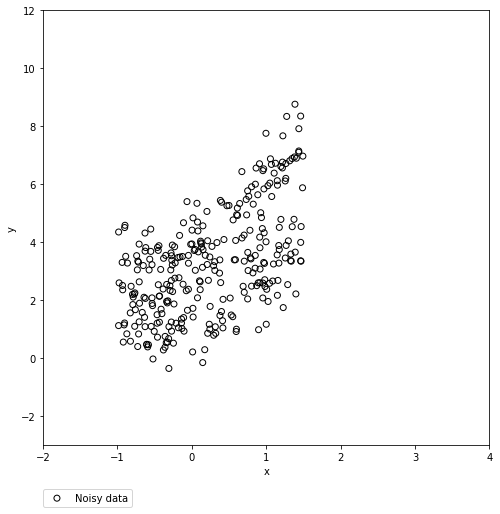

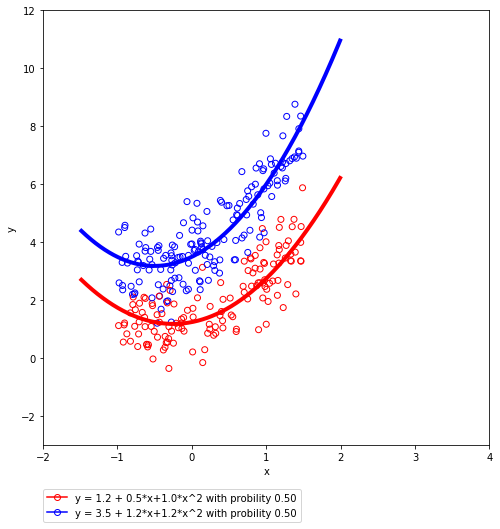

coefficients [1.13440722 2.1147955 ] with probability [0.41590405]
coefficients [0.48357392 2.08498413] with probability [0.28717465]
coefficients [-1.06588491 -2.04197585] with probability [0.09619517]
coefficients [0.48748251 2.05216413] with probability [0.0560432]
coefficients [-1.06466088 -2.04860016] with probability [0.04325439]
coefficients [0.47939503 2.085457  ] with probability [0.04140997]
coefficients [0.34736725 2.97414618] with probability [0.02589498]


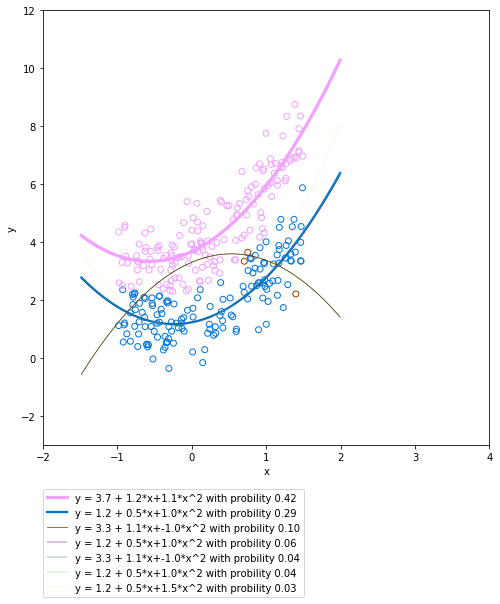

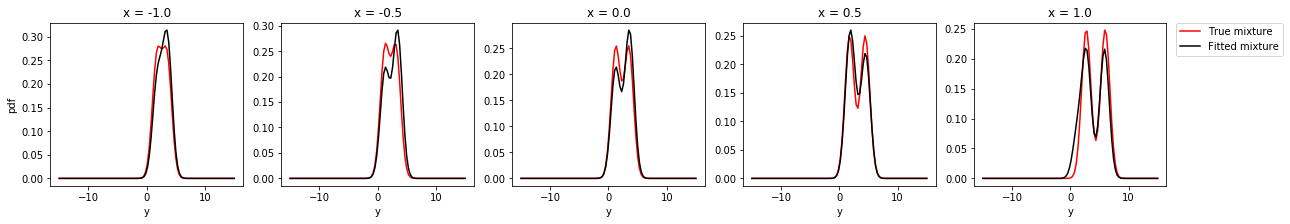

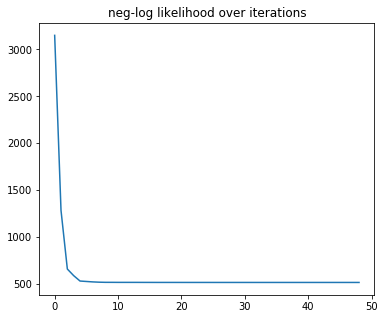

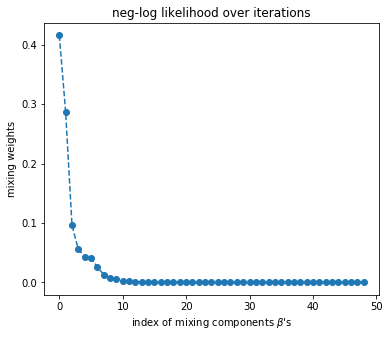

In [11]:
#colorful
test_NonLinear(300,50,(0.5,2),(1,2.5),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8)

beta_sol [-0.83291216 20.35334785]
beta_sol [7.64540616 1.60103517]
beta_sol [4.52498377 0.51324357]
beta_sol [ -0.17459732 -20.55159107]
beta_sol [1.1771095  2.02414132]
beta_sol [-0.11878372 -7.05323478]
beta_sol [0.5751462  4.79652622]
beta_sol [0.51602394 3.55252548]
beta_sol [5.19034469 7.19459998]
beta_sol [4.41448116 3.00716999]
beta_sol [1.21115754 0.33797264]
beta_sol [0.93461452 1.1272747 ]
beta_sol [0.73957276 0.41344498]
beta_sol [ 0.56540239 23.9540856 ]
beta_sol [5.0168845  3.98958701]
beta_sol [4.42892104 5.79124688]
beta_sol [ 0.5507419  19.48028835]
beta_sol [ 0.55189295 19.77375876]
beta_sol [ 0.55105082 19.72658036]
beta_sol [0.79021625 0.84313928]
beta_sol [0.86160415 0.99746134]
beta_sol [ 0.63809029 23.16689327]
beta_sol [ 0.63533722 22.73249031]
beta_sol [ 0.63448892 22.75318423]
beta_sol [6.13669353 5.31781738]
beta_sol [ 0.63617372 22.58904996]
beta_sol [ 0.63531997 22.56702084]
beta_sol [ 0.63405148 22.55170671]
beta_sol [ 0.63490499 22.53418469]
beta_sol [ 0.

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


beta_sol [  0.6031004 348.9641305]
beta_sol [0.88460839 0.96629188]
averge beta is  [[2.93555269]
 [3.64762644]]
training error is  36.21111010642986
final neg log likelihood is  1893.9788568747713
number of components is 77
only components with probability at least  0.02  are shown below:


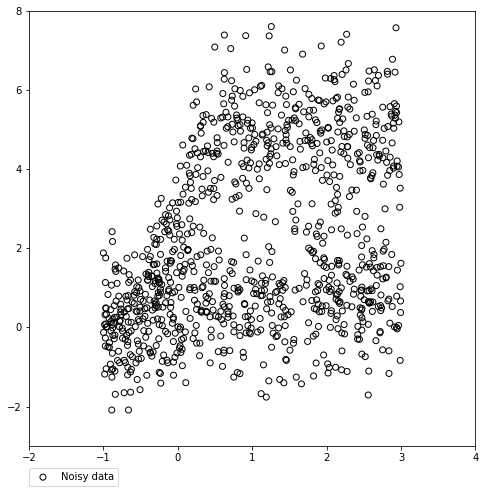

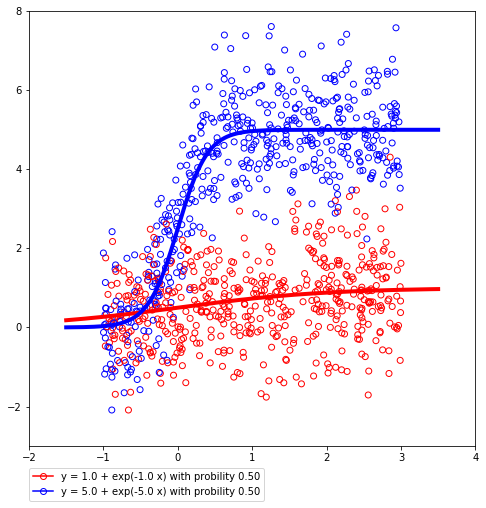

coefficients [4.89937851 5.01181675] with probability [0.23430076]
coefficients [0.88566611 0.96644192] with probability [0.15299869]
coefficients [4.94377399 5.02036171] with probability [0.12709779]
coefficients [0.88460839 0.96629188] with probability [0.09589266]
coefficients [0.88375607 0.96819962] with probability [0.08052094]
coefficients [4.94967475 5.14321318] with probability [0.07431882]
coefficients [0.88485232 0.96631718] with probability [0.06225588]
coefficients [0.88700759 0.96370377] with probability [0.04857709]
coefficients [5.86050967 5.65791846] with probability [0.0337251]
coefficients [4.83399052 4.89822386] with probability [0.02777237]


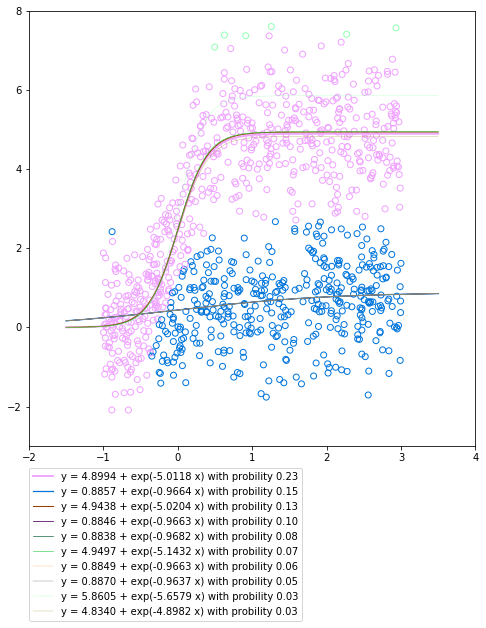

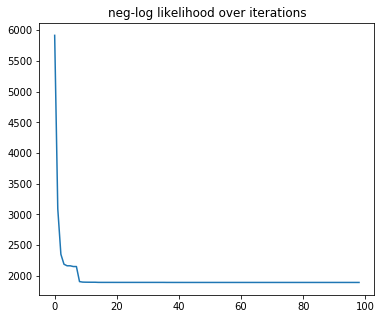

In [11]:
#colorful
test_NonLinear(1000,100,(1,1),(5,5),(1,1),0.5,0.5,sigma = 1,sigma_est = 1)